In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

from utility import *
from model_utility import *

In [2]:
LOOKBACK = 61
TRAIN_SPLIT_RATIO = 0.9
columns = [OPEN_INDEX, HIGH_INDEX, LOW_INDEX, CLOSE_INDEX, VOLUME_INDEX]

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
todays_date = datetime.now().strftime('%Y-%m-%d')
download_monthly_klines('spot', [BTC], ['15m'], '2019-01-01', todays_date, 'train')

Found 1 symbols
[1/1] - start download monthly BTCUSDT klines 

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-01.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-02.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-03.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-04.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-05.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-06.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-07.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-08.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-09.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-10.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-11.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2019-12.zip

file already exists! /content/train/BTCUSDT/BTCUSDT-15m-2020-01.zip

file already exists! /content/train/BTC

In [5]:
dataframe = get_data('train', BTC)

train/BTCUSDT/BTCUSDT-15m-2019-01.csv
train/BTCUSDT/BTCUSDT-15m-2019-02.csv
train/BTCUSDT/BTCUSDT-15m-2019-03.csv
train/BTCUSDT/BTCUSDT-15m-2019-04.csv
train/BTCUSDT/BTCUSDT-15m-2019-05.csv
train/BTCUSDT/BTCUSDT-15m-2019-06.csv
train/BTCUSDT/BTCUSDT-15m-2019-07.csv
train/BTCUSDT/BTCUSDT-15m-2019-08.csv
train/BTCUSDT/BTCUSDT-15m-2019-09.csv
train/BTCUSDT/BTCUSDT-15m-2019-10.csv
train/BTCUSDT/BTCUSDT-15m-2019-11.csv
train/BTCUSDT/BTCUSDT-15m-2019-12.csv
train/BTCUSDT/BTCUSDT-15m-2020-01.csv
train/BTCUSDT/BTCUSDT-15m-2020-02.csv
train/BTCUSDT/BTCUSDT-15m-2020-03.csv
train/BTCUSDT/BTCUSDT-15m-2020-04.csv
train/BTCUSDT/BTCUSDT-15m-2020-05.csv
train/BTCUSDT/BTCUSDT-15m-2020-06.csv
train/BTCUSDT/BTCUSDT-15m-2020-07.csv
train/BTCUSDT/BTCUSDT-15m-2020-08.csv
train/BTCUSDT/BTCUSDT-15m-2020-09.csv
train/BTCUSDT/BTCUSDT-15m-2020-10.csv
train/BTCUSDT/BTCUSDT-15m-2020-11.csv
train/BTCUSDT/BTCUSDT-15m-2020-12.csv
train/BTCUSDT/BTCUSDT-15m-2021-01.csv
train/BTCUSDT/BTCUSDT-15m-2021-02.csv
train/BTCUSD

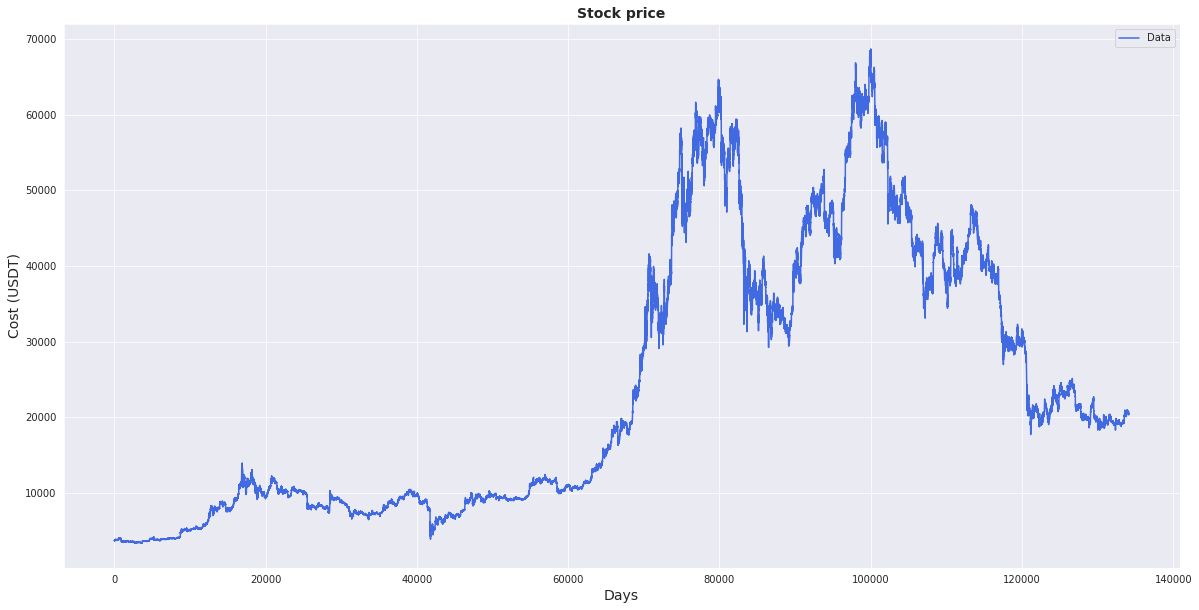

In [6]:
dataframe = dataframe[dataframe[IGNORE_INDEX] == 0]
plot_graph(pd.DataFrame(dataframe[CLOSE_INDEX].values))

In [7]:
scalers = {}
for col in columns:
    scaler = MinMaxScaler().fit(dataframe[[col]])
    dataframe[col] = scaler.transform(dataframe[[col]])
    scalers[col] = scaler

dataframe = dataframe[columns]

In [21]:
print(scalers)

{1: MinMaxScaler(), 2: MinMaxScaler(), 3: MinMaxScaler(), 4: MinMaxScaler(), 5: MinMaxScaler()}


In [8]:
x_train, y_train, x_test, y_test = split_data(dataframe, LOOKBACK, TRAIN_SPLIT_RATIO, CLOSE_INDEX-1)

print('x_train.shape = {}'.format(x_train.shape))
print('y_train.shape = {}'.format(y_train.shape))
print('x_test.shape = {}'.format(x_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

x_train.shape = (120668, 60, 5)
y_train.shape = (120668,)
x_test.shape = (13407, 60, 5)
y_test.shape = (13407,)


In [9]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [10]:
input_dim = x_train.shape[1]
output_dim = 1

batch_size = 1000

In [11]:
train_dataset = CryptocurrencyDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [12]:
test_dataset = CryptocurrencyDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(CNN_LSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(60, 128, 3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(128, 256, 3)
        self.relu2 = nn.ReLU()
        self.lstm1 = nn.LSTM(1, 64)
        self.fc1 = nn.Linear(64, 1)
        self.lstm2 = nn.LSTM(256, 1)
        self.fc2 = nn.Linear(1, 1)
        
    def observe_outputs(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        print('After conv1: {}'.format(x.size()))

        x = self.conv2(x)
        x = self.relu2(x)
        print('After conv2: {}'.format(x.size()))
        
        x, _ = self.lstm1(x)
        print('After lstm1: {}'.format(x.size()))
        
        x = self.fc1(x)
        print('After fc1: {}'.format(x.size()))

        x, _ = self.lstm2(x.T)
        print('After lstm2: {}'.format(x.size()))

        x = self.fc2(x)
        print('After fc2: {}'.format(x.size()))
        
    def forward(self, x):
        T_x, n_x, m = x.shape

        output = torch.zeros((T_x, 1), device=device)
        for t in range(T_x):
            out = self.conv1(x[t])
            out = self.relu1(out)
            out = self.conv2(out)
            out = self.relu2(out)
            out, _ = self.lstm1(out)
            out = self.fc1(out)
            out, _ = self.lstm2(out.T)
            out = self.fc2(out)
            output[t, :] = out

        return output

In [14]:
def test_forward():
    cnn_lstm = CNN_LSTM(input_dim, output_dim).to(device)

    x = torch.randn(60, 5).to(device)
    with torch.no_grad():
        cnn_lstm.observe_outputs(x)

test_forward()

After conv1: torch.Size([128, 3])
After conv2: torch.Size([256, 1])
After lstm1: torch.Size([256, 64])
After fc1: torch.Size([256, 1])
After lstm2: torch.Size([1, 1])
After fc2: torch.Size([1, 1])


In [15]:
num_params = count_parameters(CNN_LSTM(input_dim, output_dim))
print('Total number of parameters: {}'.format(num_params))

Total number of parameters: 139983


In [16]:
cnn_lstm = CNN_LSTM(input_dim, output_dim).to(device)

optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=0.01)

loss = nn.MSELoss()

print(cnn_lstm)

CNN_LSTM(
  (conv1): Conv1d(60, 128, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (lstm1): LSTM(1, 64)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (lstm2): LSTM(256, 1)
  (fc2): Linear(in_features=1, out_features=1, bias=True)
)


In [17]:
history = model_train(cnn_lstm, optimizer, loss, 5, train_loader, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([668])) that is different to the input size (torch.Size([668, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 MSE: 0.44076913016345265
Epoch: 2 MSE: 0.041339546444393825
Epoch: 3 MSE: 0.10684444131545838
Epoch: 4 MSE: 0.09928141709170829
Epoch: 5 MSE: 0.09978894629061814
Training time: 0:26:35.207977


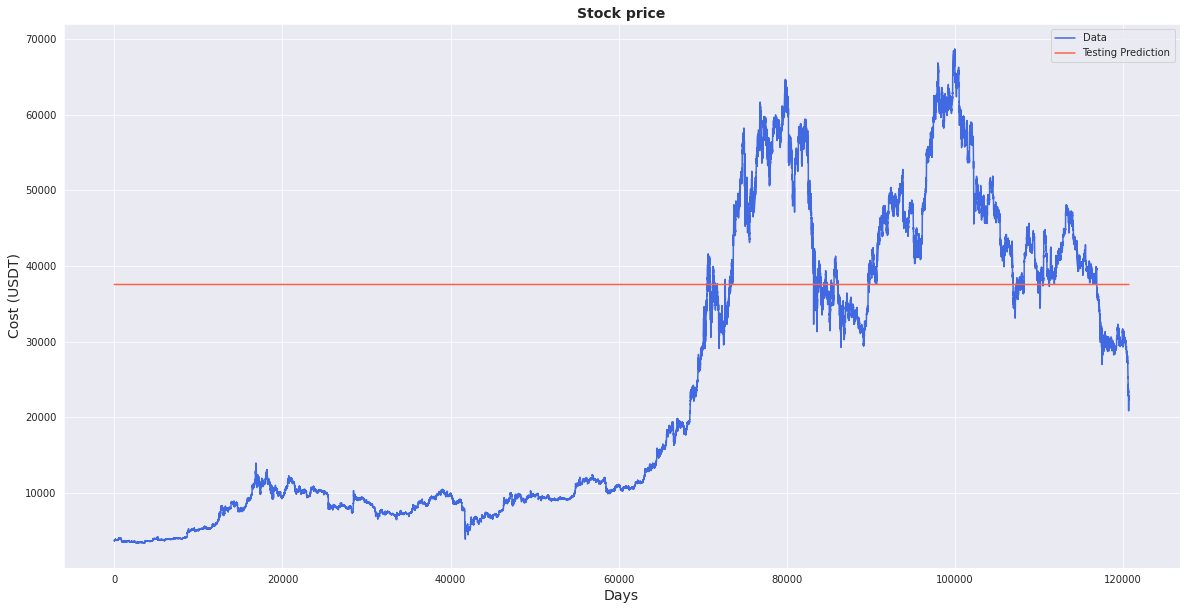

In [18]:
y_train_pred = model_predictions1(cnn_lstm, train_loader, device, scalers[CLOSE_INDEX])

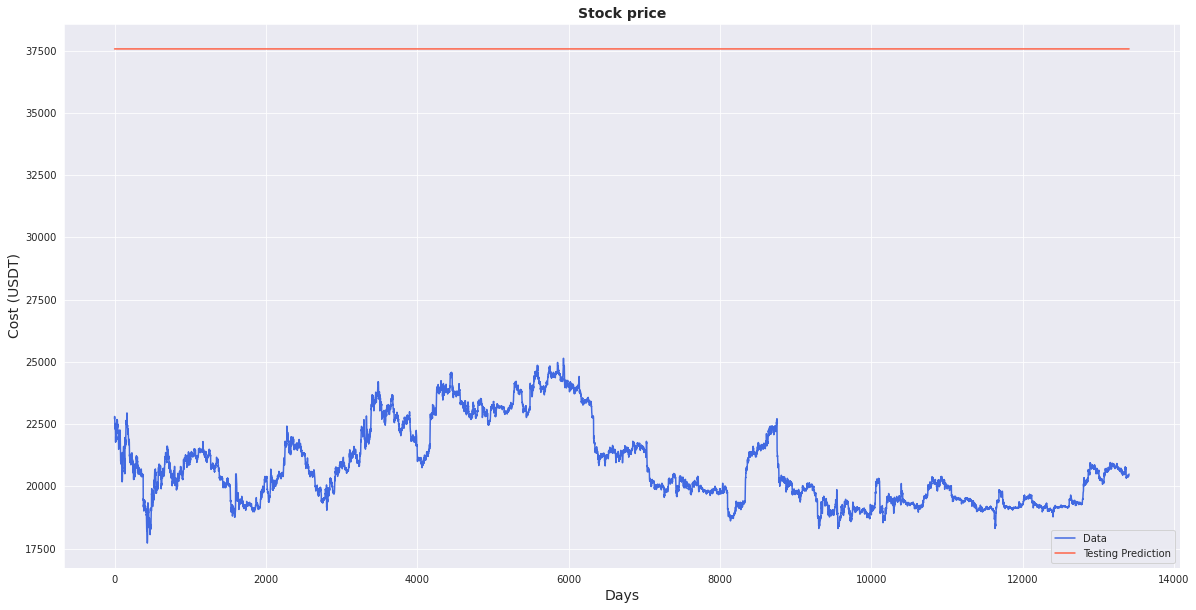

In [22]:
y_test_pred = model_predictions1(cnn_lstm, test_loader, device, scalers[CLOSE_INDEX])

In [20]:
rmse(y_train.detach().cpu().numpy(), y_train_pred, 'Train')
rmse(y_test.detach().cpu().numpy(), y_test_pred, 'Test')

Train Score: 0.354 RMSE
Test Score: 0.257 RMSE
